# Corona prepping using Finnish data EDA

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix,
                     summary_performance_metrics_classification)

# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit
# from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn.model_selection import KFold

In [5]:
# from sklearn import tree
# import graphviz

In [6]:
from catboost import CatBoostClassifier, Pool

In [7]:
# import xgboost
import shap
shap.initjs()

In [8]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [9]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [10]:
df = pd.read_csv("data/shield_gjames_21-06-10.csv").drop("id", axis=1)

In [11]:
df.head()

demographic_gender demographic_age  demographic_4_areas  \
0                   1           50-59                    1   
1                   2           30-39                    2   
2                   1           18-29                    1   
3                   1             60+                    1   
4                   1             60+                    2   

   demographic_8_areas  behaviour_indoors_nonhouseholders  \
0                    2                                  5   
1                    6                                  5   
2                    2                                  3   
3                    2                                  4   
4                    7                                  5   

   behaviour_close_contact  behaviour_quarantined  behaviour_unmasked  \
0                        4                      2                   5   
1                        4                      2                   5   
2                        2                      2                   2   
3                        3                      2                   2   
4                        4                      2                   4   

   mask_wearing_cloth_mask  mask_wearing_disposable_mask  ...  \
0                        0                             1  ...   
1                        1                             1  ...   
2                        0                             1  ...   
3                        0                             0  ...   
4                        0                             1  ...   

   sdt_motivation_introjected_3  attention_check  \
0                             2                2   
1                             7                1   
2                             3                1   
3                             5                2   
4                             6                1   

   vaccination_status_intention_self  vaccination_status_closeones  \
0                                  1                             1   
1                                  2                             2   
2                                  3                             1   
3                                  1                             2   
4                                  1                             4   

   covid_tested  had_covid  demographic_risk_group  \
0             1          1                       2   
1             3          2                       2   
2             2          5                       2   
3             2          2                       1   
4             3          1                       2   

   needprotection_before_shots  needprotection_after_1_shot  \
0                            1                            2   
1                            1                            2   
2                            1                            1   
3                            2                            2   
4                            1                            1   

   needprotection_after_2_shots  
0                             3  
1                             5  
2                             7  
3                             2  
4                             3  

[5 rows x 92 columns]

In [12]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [13]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [14]:
df.shape

(2272, 73)

## Force all variables to categorical data

In [15]:
df = df.astype("category")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 73 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   demographic_gender                 2272 non-null   category
 1   demographic_age                    2272 non-null   category
 2   demographic_4_areas                2272 non-null   category
 3   demographic_8_areas                2272 non-null   category
 4   behaviour_indoors_nonhouseholders  2272 non-null   category
 5   behaviour_close_contact            2272 non-null   category
 6   behaviour_quarantined              2272 non-null   category
 7   behaviour_unmasked                 2272 non-null   category
 8   mask_wearing_cloth_mask            2272 non-null   category
 9   mask_wearing_disposable_mask       2272 non-null   category
 10  mask_wearing_certified_mask        2272 non-null   category
 11  mask_wearing_ffp2                  2272 non

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [17]:
# Consider the interested group to analyze
grouping_var = "behaviour_unmasked"#"Q5" 

# Consider only numerical features
features_list = df.drop(grouping_var, axis=1).columns.tolist()
# features_list = code_df.loc[code_df["Of primary interest as a predictor (i.e. feature)?"]!="no", "Variable name"].values.tolist()
# make sure the target is not included in the features_list
try:
    _ = features_list.remove(grouping_var)
except:
    print(f"The grouping variable {grouping_var} was not present in the feature list to remove.")

# df[grouping_var] = df[grouping_var].astype("category")

The grouping variable behaviour_unmasked was not present in the feature list to remove.


### Creating a boolean version of the grouping variable

In [18]:
if grouping_var == "behaviour_unmasked":
    df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int) #all the answers other than 5 are considered a 1 in the boolean
elif grouping_var == "demographic_age":
    df = (df
          .assign(PT_AGE_bool=lambda x: x["demographic_age"]
                  .isin(["40-49", "50-59"]) #ages 40 - 59 are considere 1 in the boolean
                  .astype(int))
         .loc[df["PT_AGE"] != "60+", :])
# elif grouping_var == "Q8_3":
#     df = df.assign(Q8_3_bool=lambda x: x["Q8_3"]
#                   .isin([1, 4]) #answers 1 and 4 are considered 1 in the boolean
#                   .astype(int))
else:
    raise ValueError(f"The grouping variable {grouping_var} is not currently supported, please choose from Q5, Q8_3 or PT_AGE.")

## EDA on the target
Check the amount of samples in the target

In [19]:
print(df[grouping_var].value_counts())
print(df[f"{grouping_var}_bool"].value_counts())

5    881
4    823
3    277
1    165
2    126
Name: behaviour_unmasked, dtype: int64
1    1391
0     881
Name: behaviour_unmasked_bool, dtype: int64


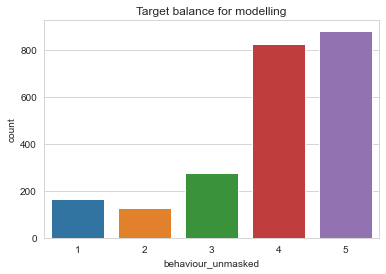

In [20]:
_ = sns.countplot(x=df[grouping_var])
_ = plt.title("Target balance for modelling")
_ = plt.show()

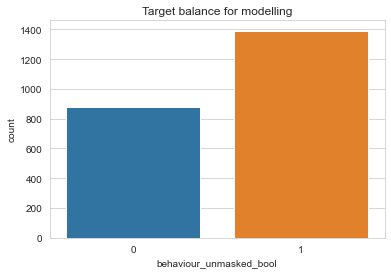

In [21]:
_ = sns.countplot(x=df[f"{grouping_var}_bool"])
_ = plt.title("Target balance for modelling")
_ = plt.show()

In [22]:
grouping_var = f"{grouping_var}_bool" #"Q5_bool"
# grouping_var = "PT_AGE_bool" #"Q5_bool"
# grouping_var = "Q5_bool"

In [23]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(30,10))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
#                     palette="Set2"
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostClassifier(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='Logloss',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 20))
    gini_plot = sns.barplot(data=feature_importance_df#[feature_importance_df["feature_importance"] != 0]
                            , 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    # model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = shap_values[:,:-1]

#     _ = plt.figure(figsize=(7, 10))
    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    # model = CatBoostClassifier(iterations=500,
    #                            depth=None,
    #                            learning_rate=1,
    #                            loss_function='Logloss',
    #                            verbose=False)

    # train the model
    _ = model.fit(X[feature_importance_df.head(2).feature.tolist()], y, cat_features=feature_importance_df.head(2).feature.tolist())

    dec_bound_plot = plot_decision_boundary(X=X[feature_importance_df.head(2).feature.tolist()], 
                               y=y, clf=model, 
                               title = f'CatBoost Decision Boundary {plot_title}', 
                               legend_title = "Mask Use")
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), dec_bound_plot, feature_importance_df, shap_actual_df

In [24]:
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = features_list[2:],
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

In [25]:
# feature_plot_0

In [26]:
# features_list[2:]

In [27]:
# df.filter(regex="sdt").columns.tolist()

In [28]:
# %%capture
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

# feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="40 - 59"
#                                                                                   )

# feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="60+"
#                                                                                   )

# feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="All"
#                                                                                   )

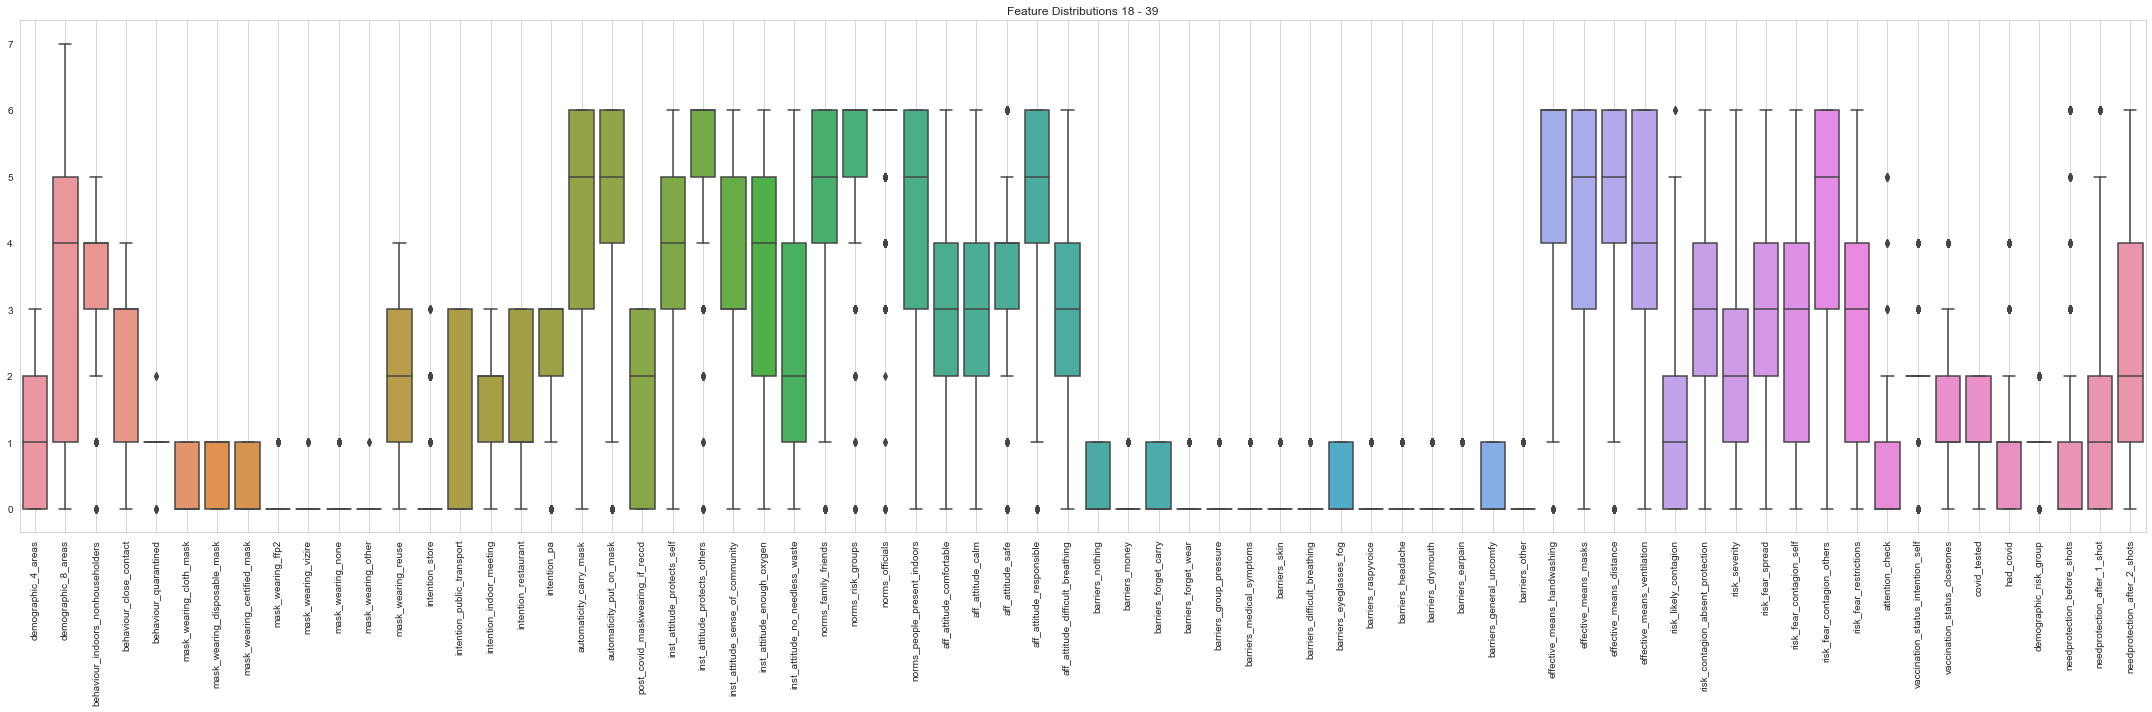

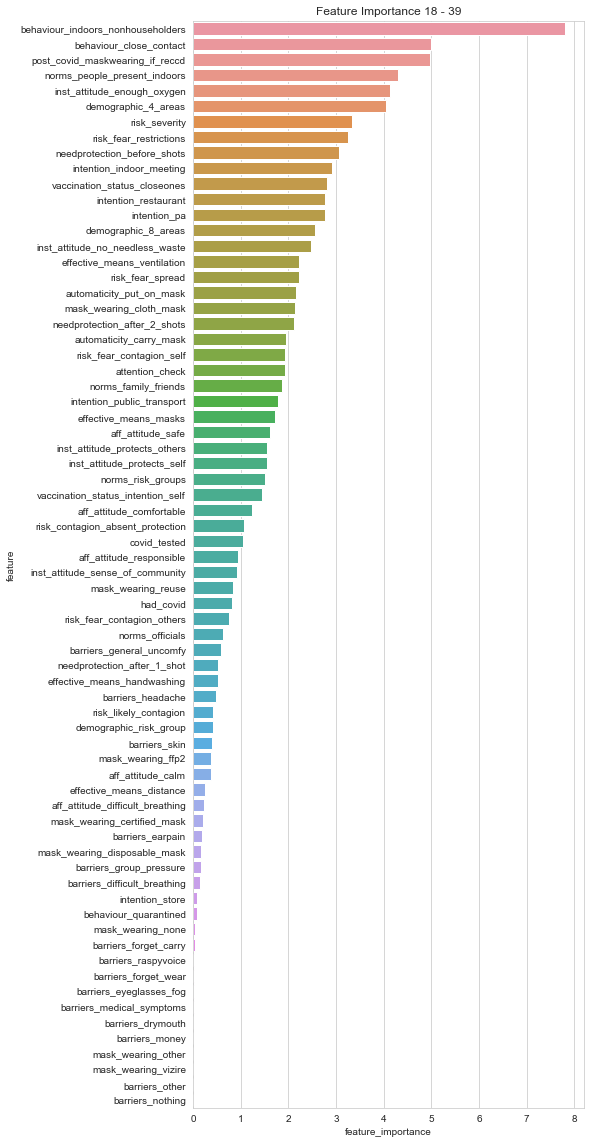

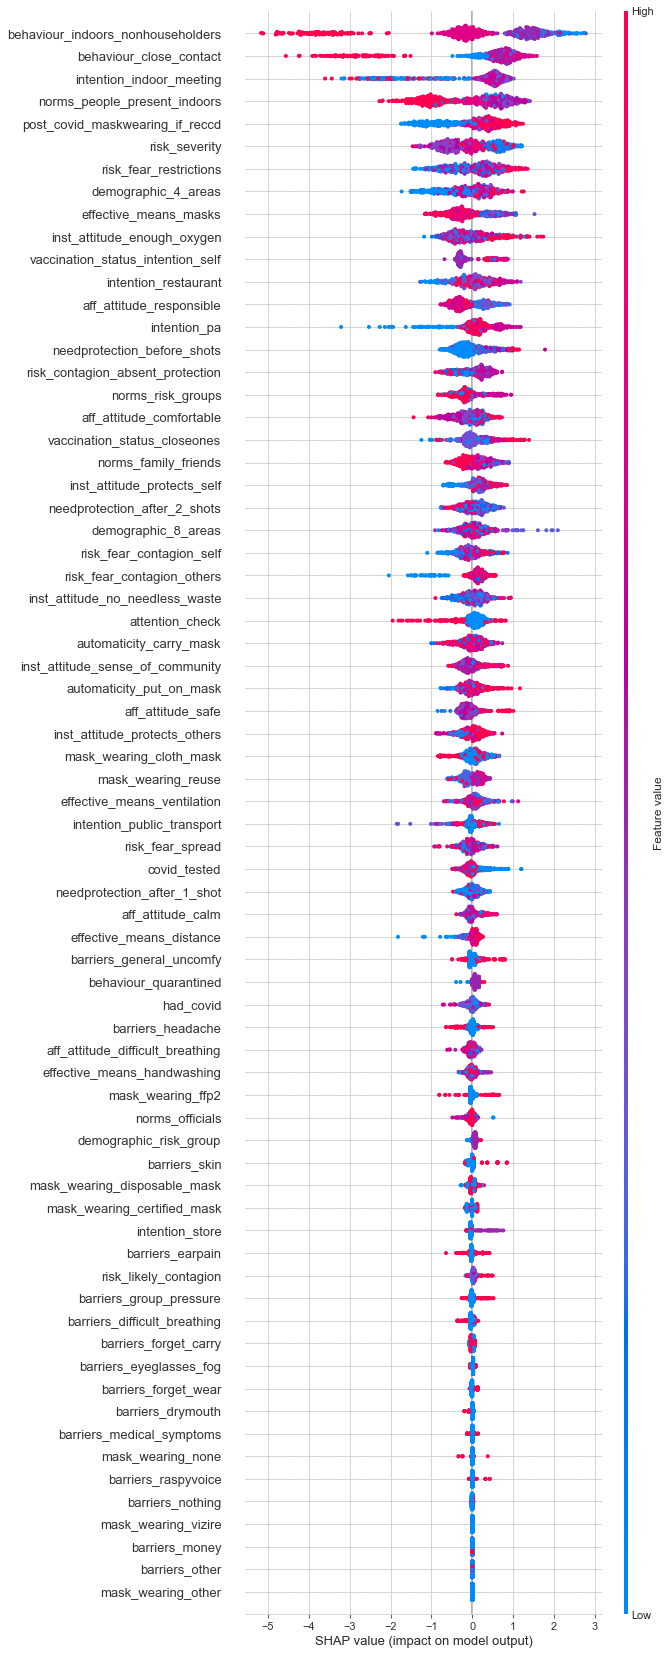

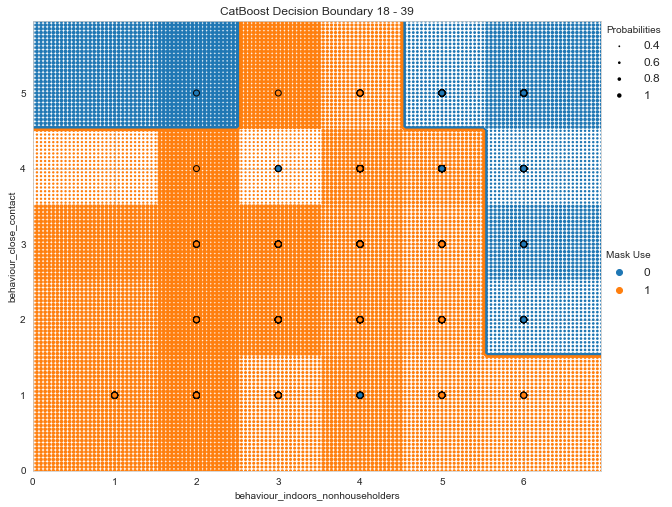

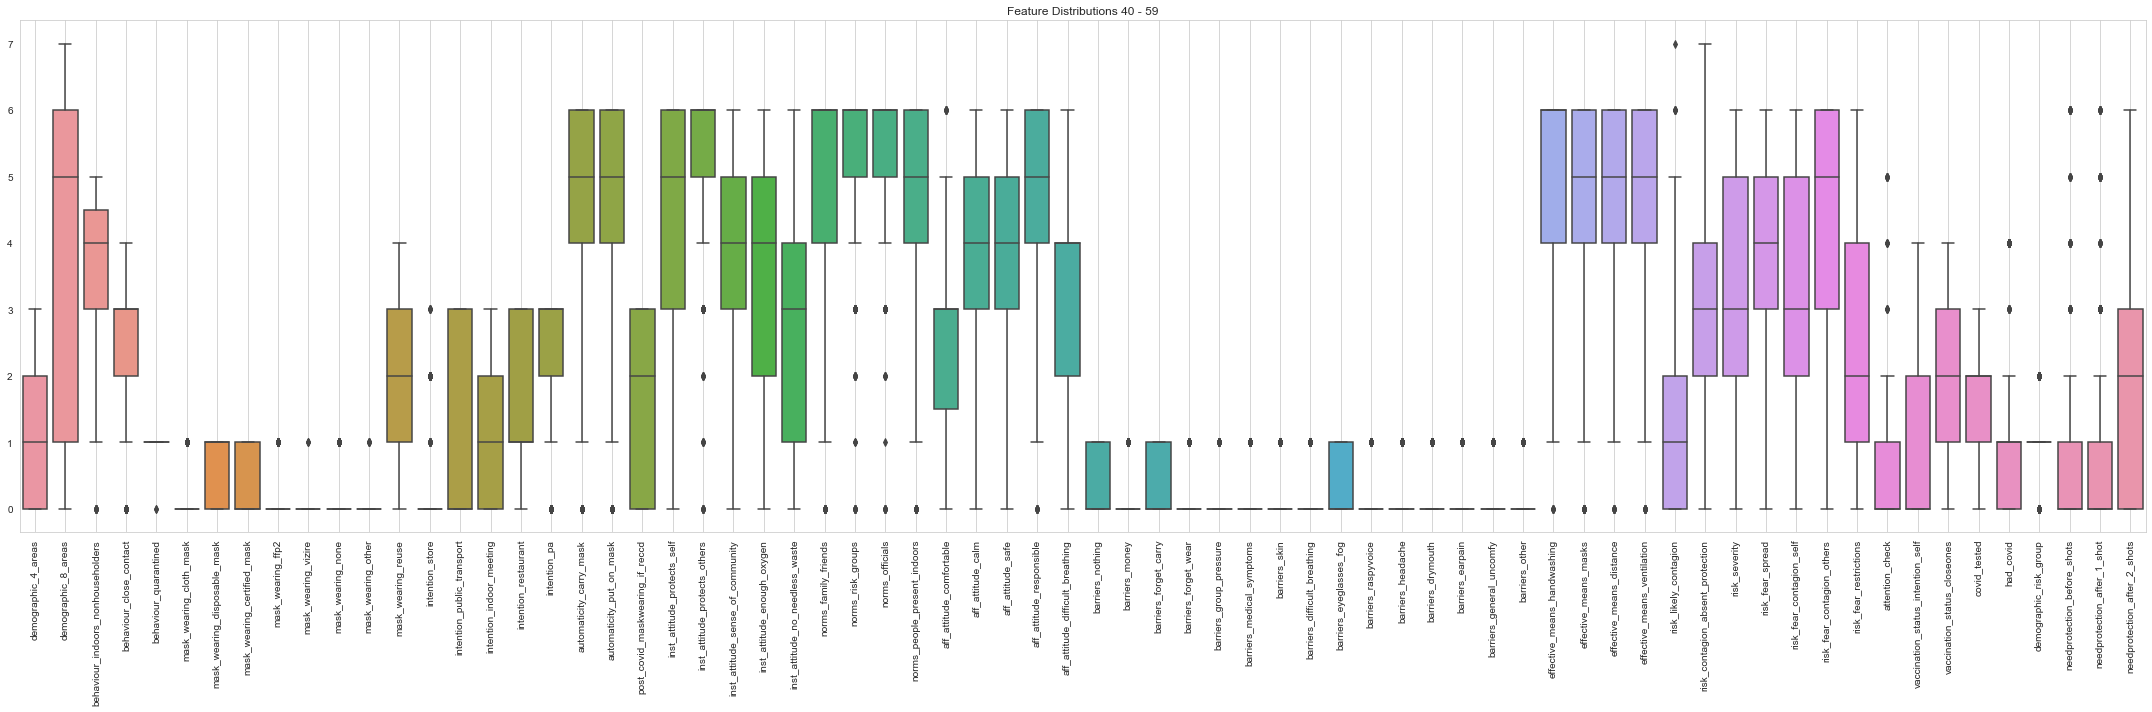

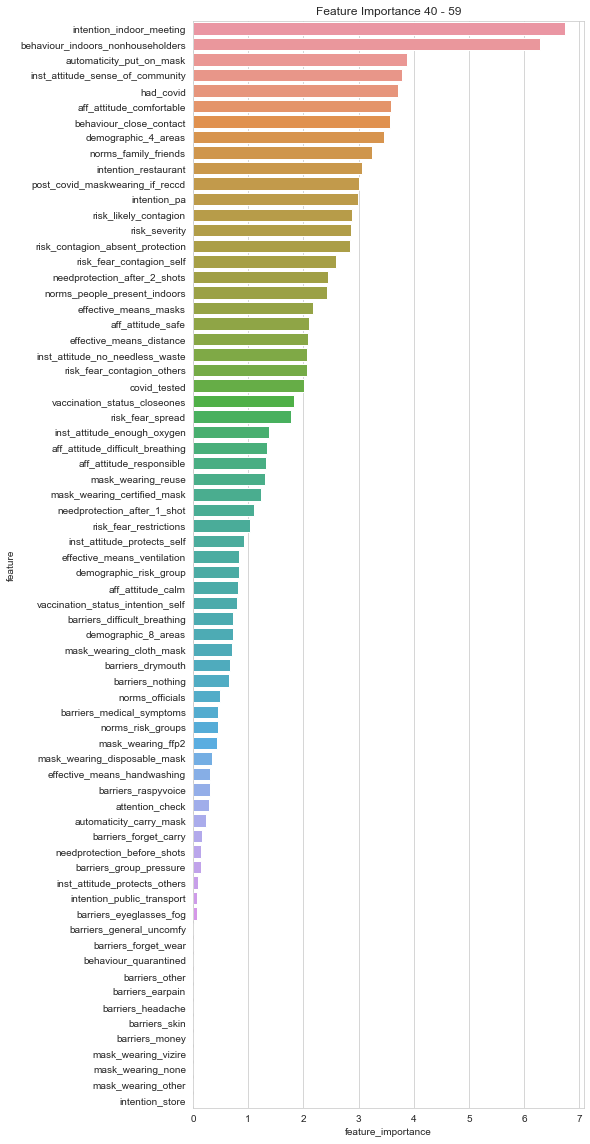

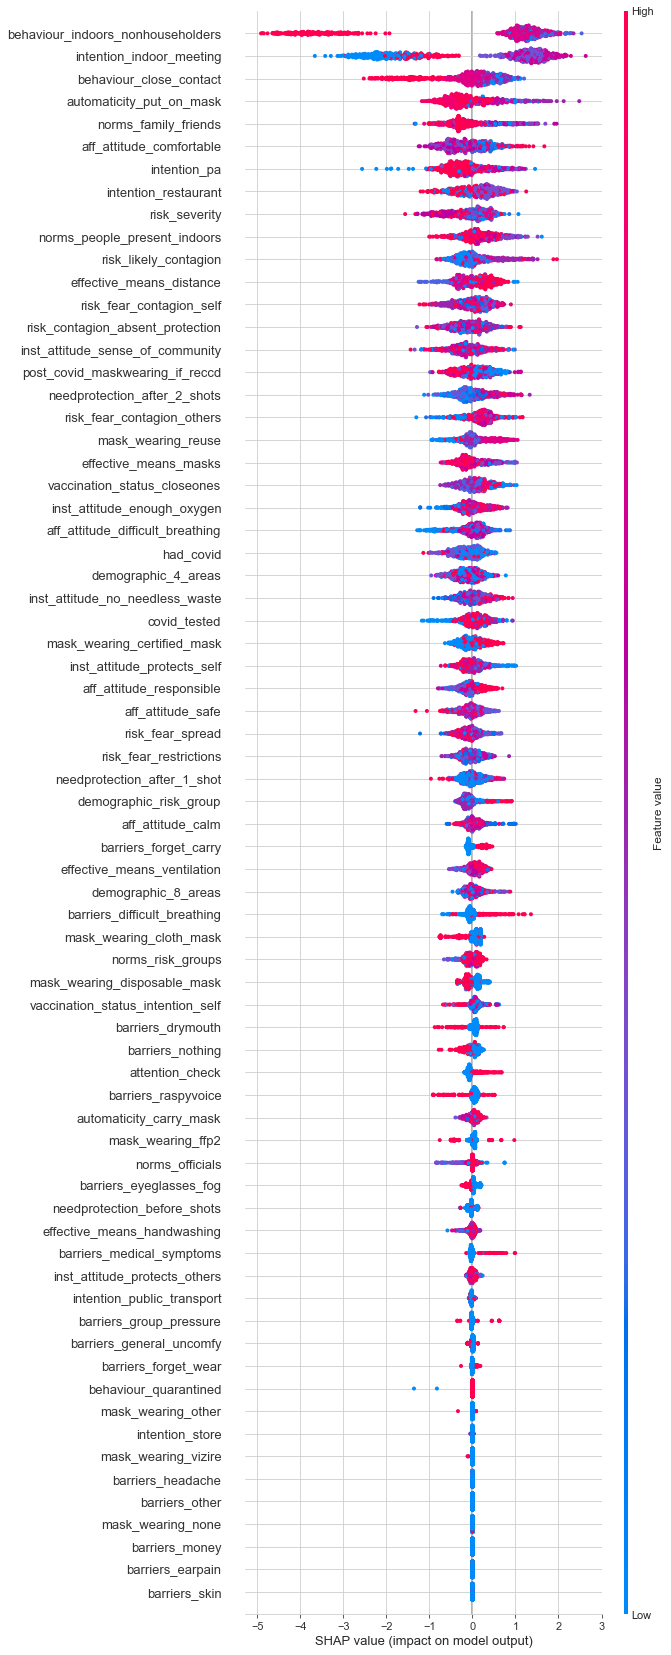

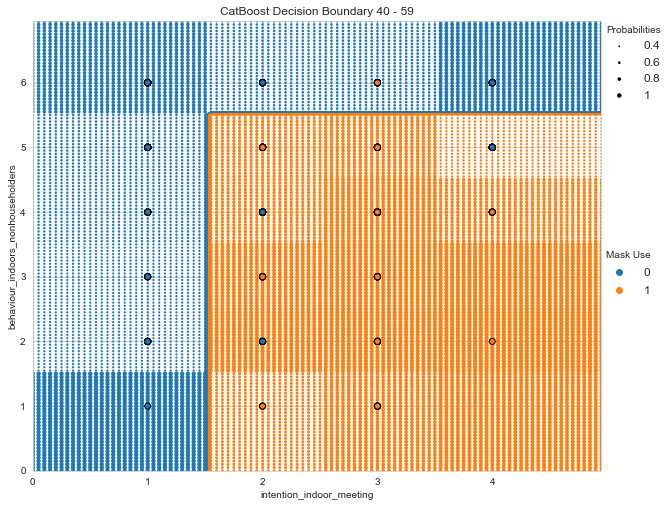

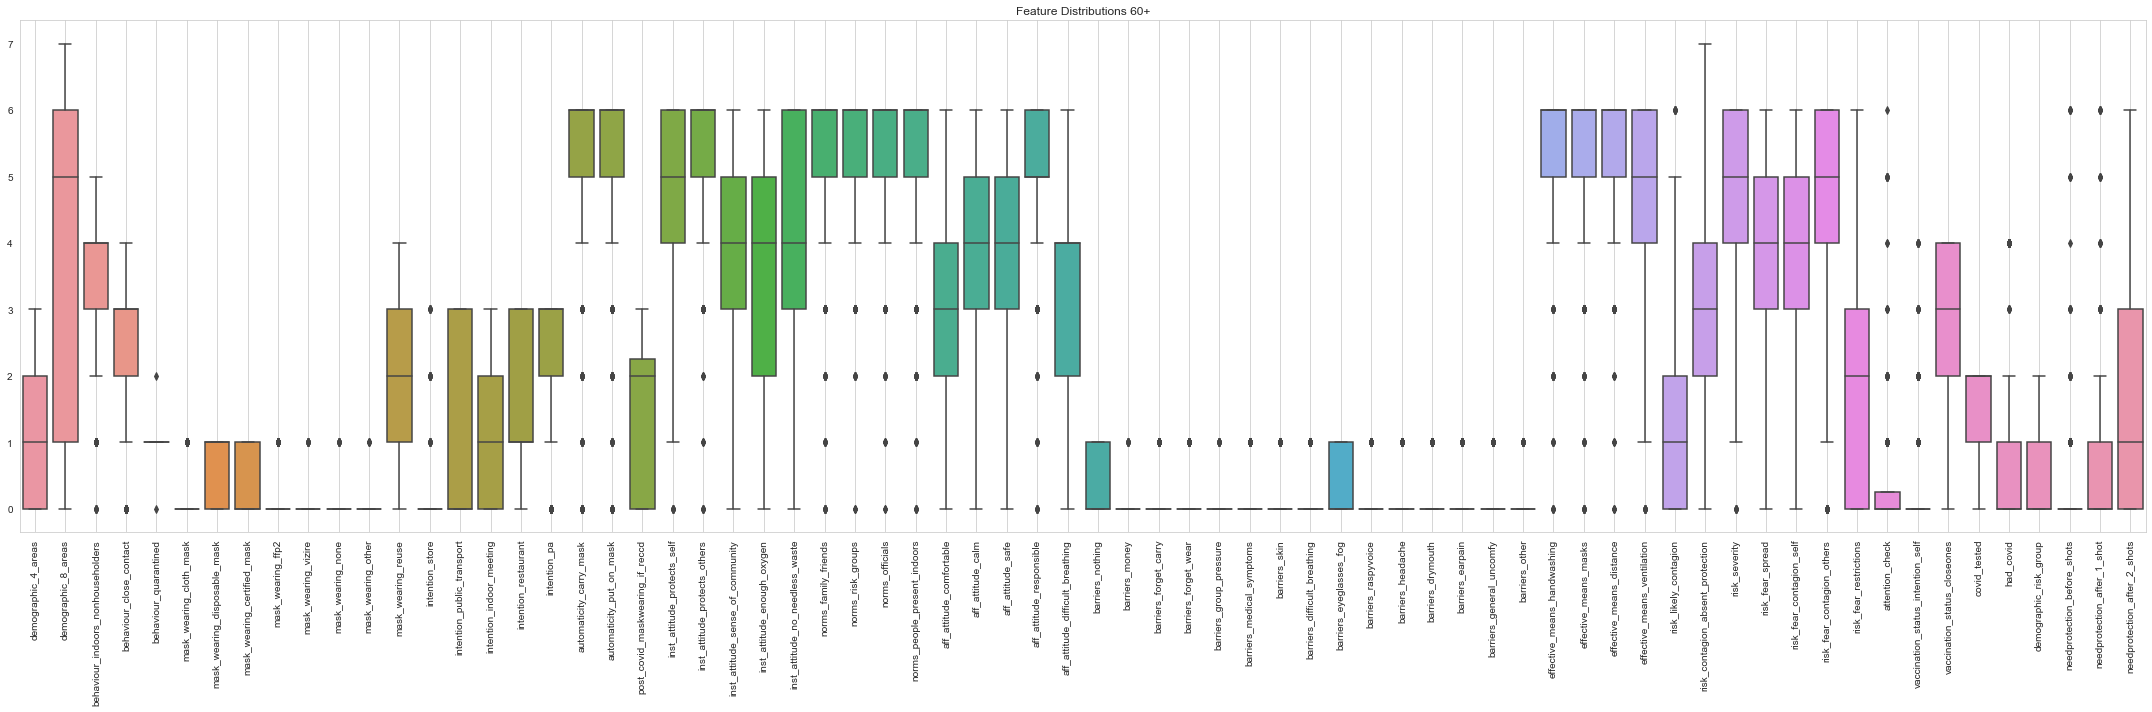

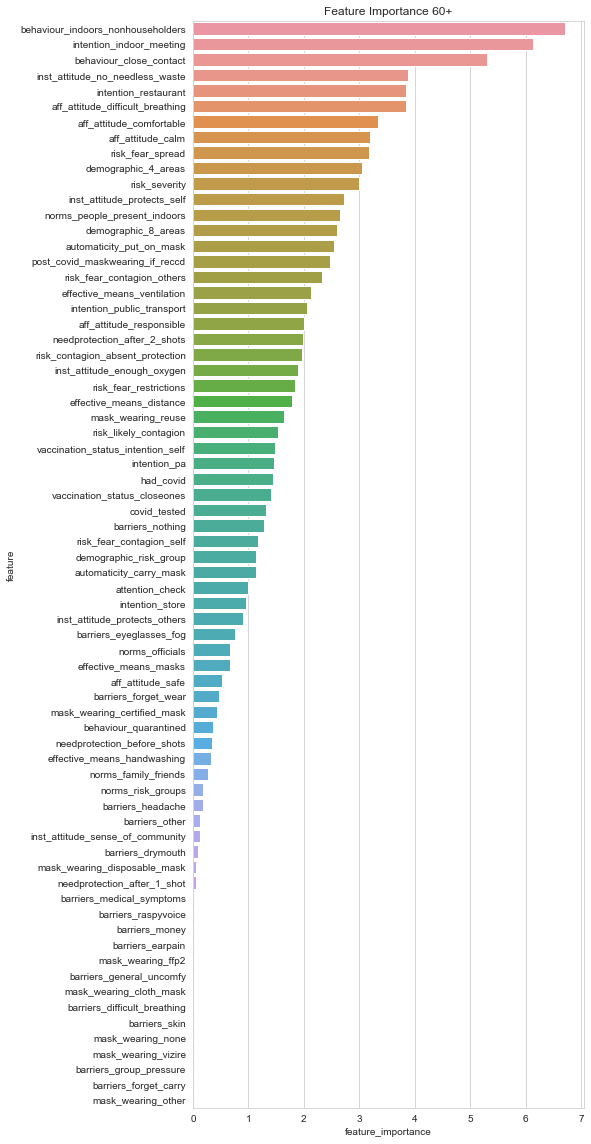

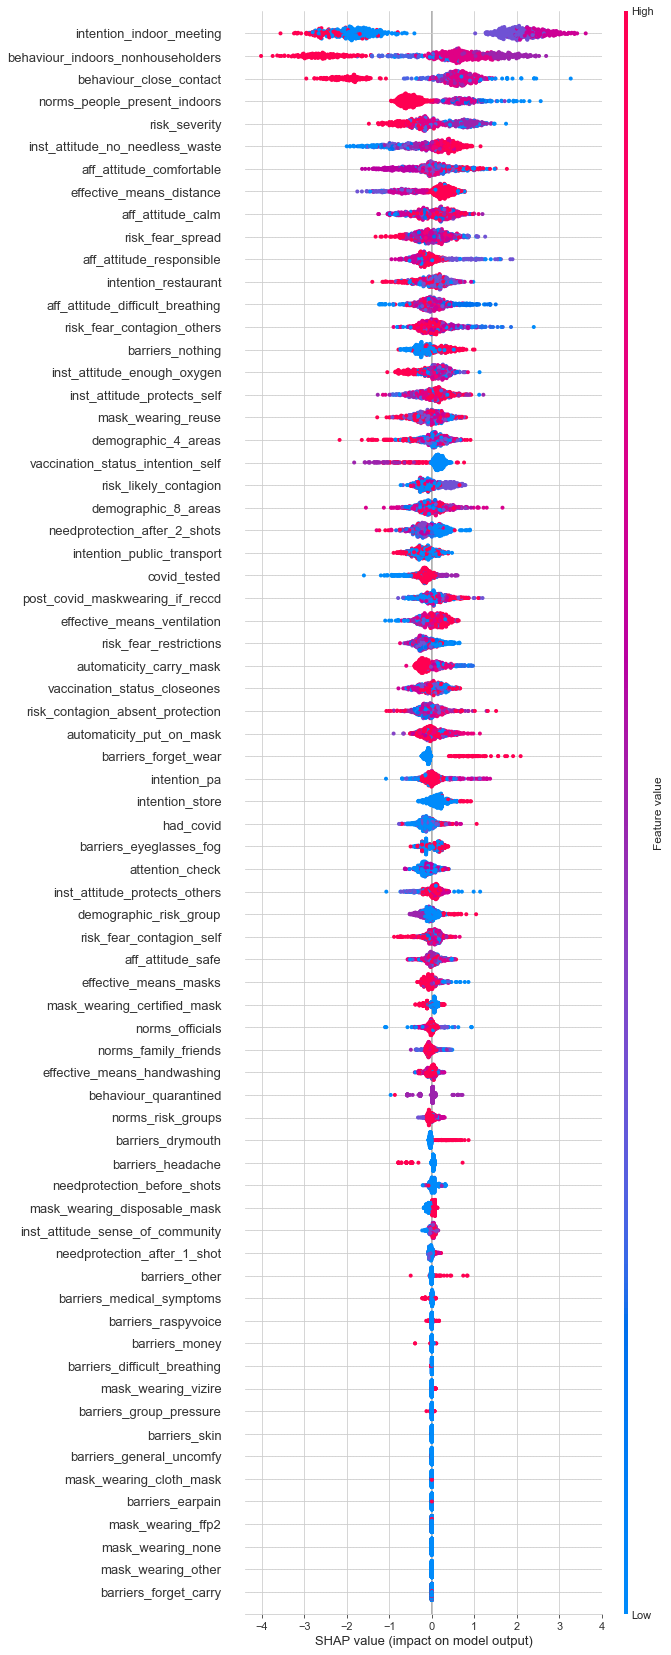

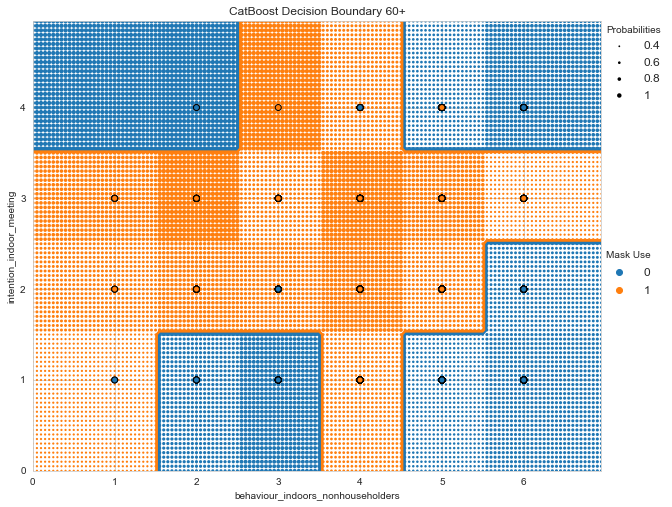

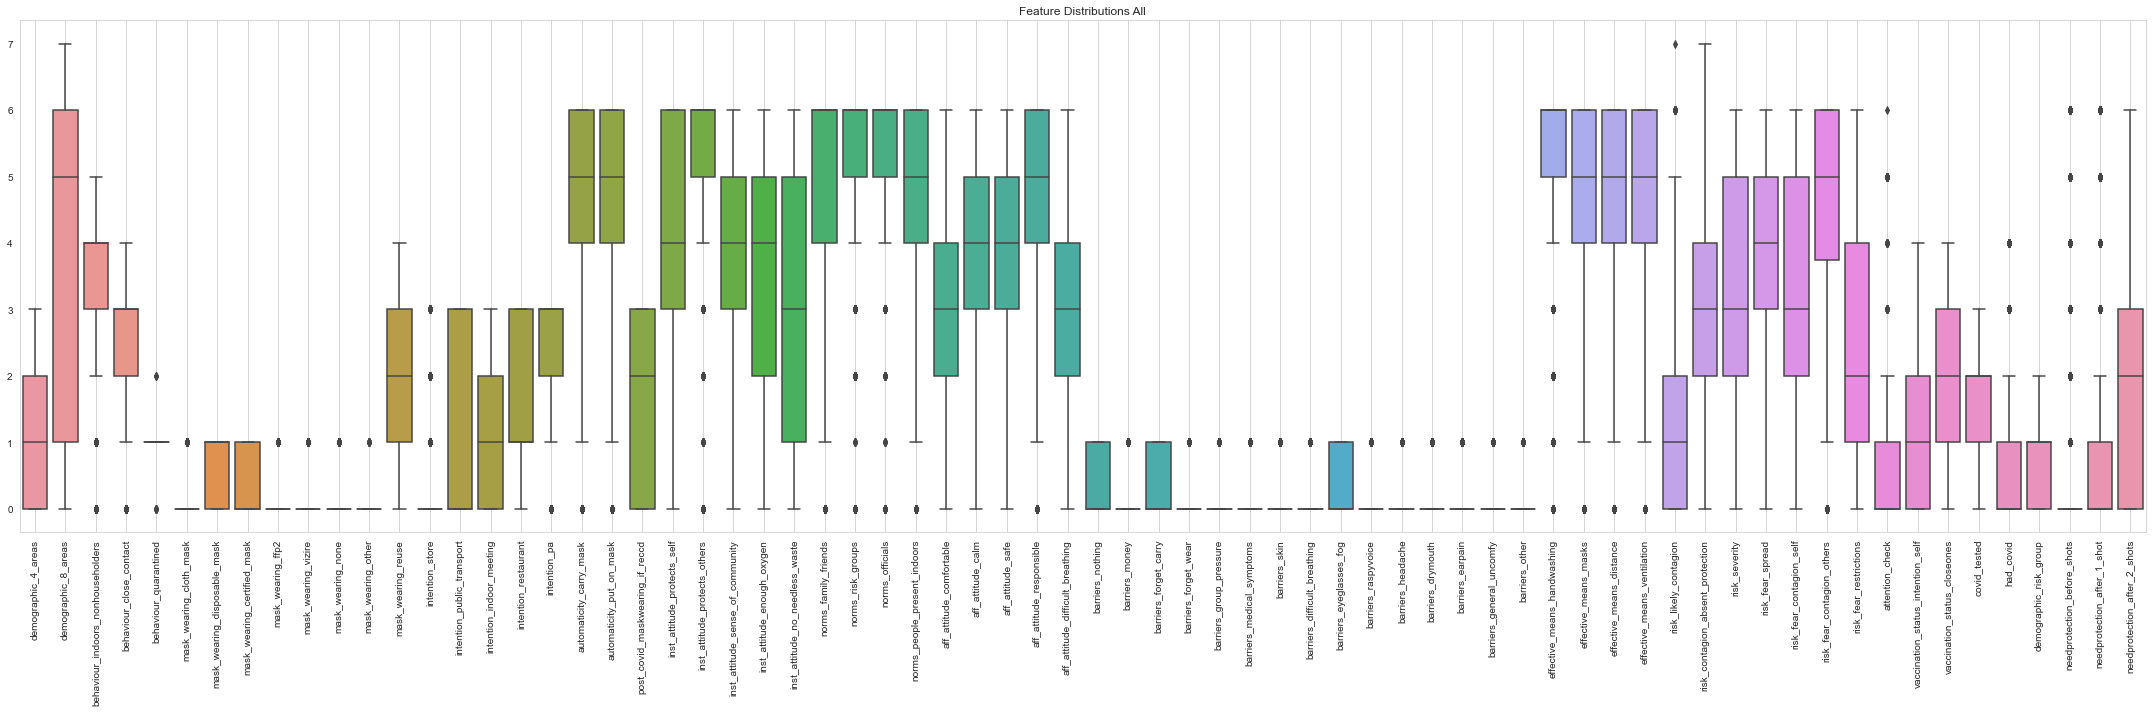

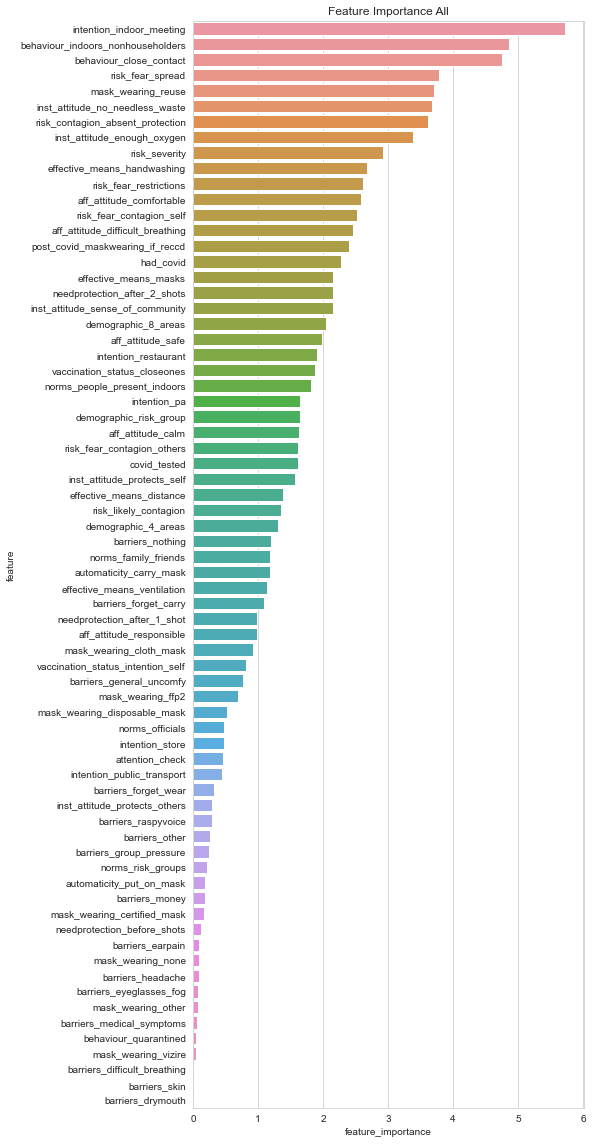

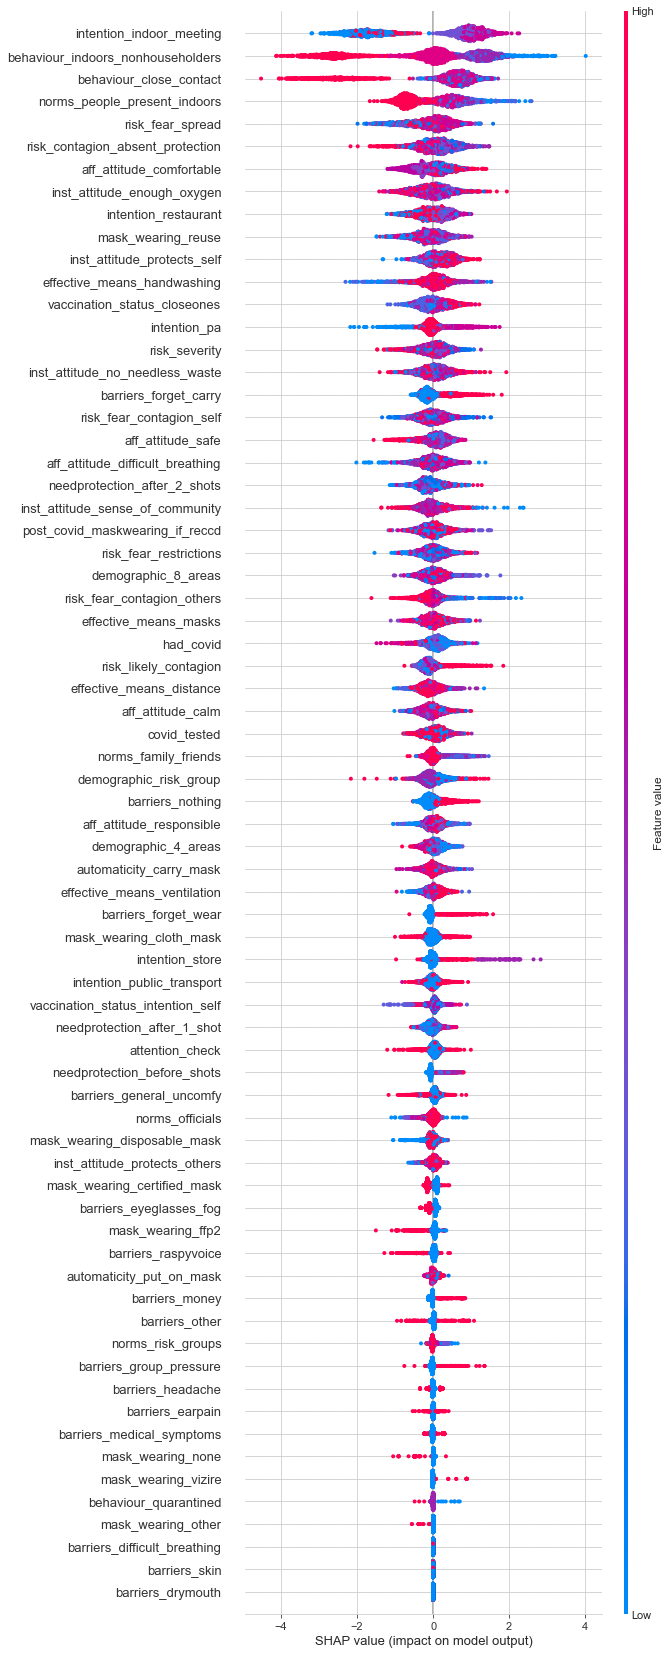

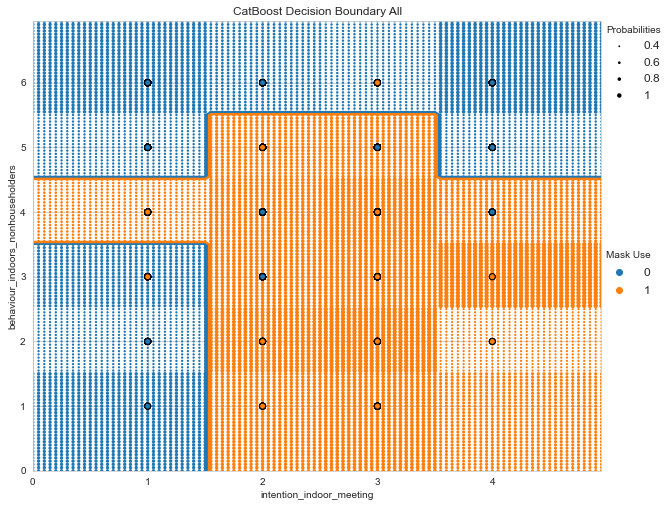

In [29]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="60+"
                                                                                  )

feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list[2:],
                                                                                                                                   plot_title="All"
                                                                                  )

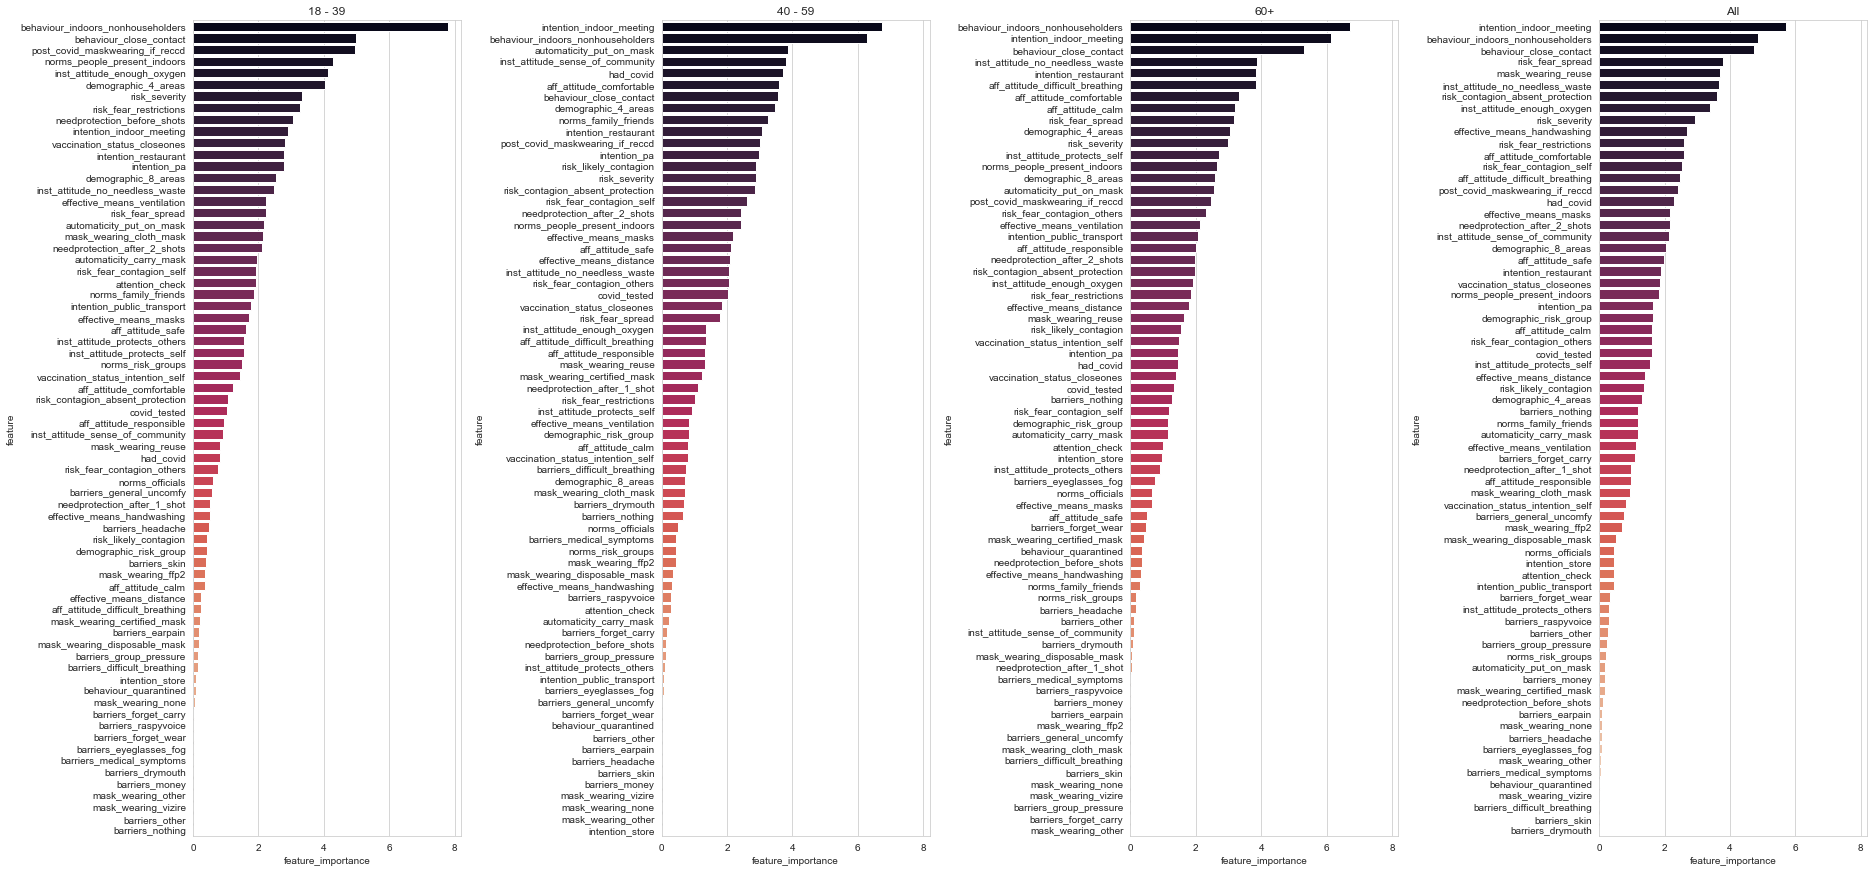

In [30]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [31]:
fig.savefig(f"images/feature_importance_age_groups.png", dpi=400, bbox_inches="tight")

In [32]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

In [33]:
# pd.concat(fi_dfs_list, axis=0).groupby("age_group").head()

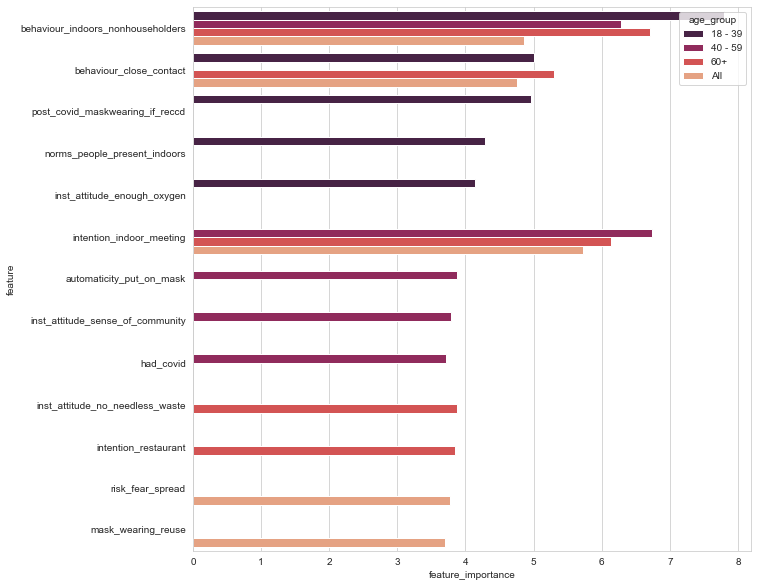

In [34]:
_ = plt.figure(figsize=(10, 10))
_ = sns.barplot(
#     data=pd.concat(fi_dfs_list, axis=0), 
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [35]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [36]:
# fis_df.columns = ['feature_young', 'feature_importance_young', 'feature_middle', 'feature_importance_middle',
#        'feature_old', 'feature_importance_old', 'feature_all', 'feature_importance_all']

In [37]:
fis_df.head(5)

feature  feature_importance age_group  \
0  behaviour_indoors_nonhouseholders                7.80   18 - 39   
1            behaviour_close_contact                5.00   18 - 39   
2    post_covid_maskwearing_if_reccd                4.96   18 - 39   
3       norms_people_present_indoors                4.29   18 - 39   
4        inst_attitude_enough_oxygen                4.14   18 - 39   

                             feature  feature_importance age_group  \
0           intention_indoor_meeting                6.74   40 - 59   
1  behaviour_indoors_nonhouseholders                6.28   40 - 59   
2           automaticity_put_on_mask                3.87   40 - 59   
3   inst_attitude_sense_of_community                3.79   40 - 59   
4                          had_covid                3.71   40 - 59   

                             feature  feature_importance age_group  \
0  behaviour_indoors_nonhouseholders                6.71       60+   
1           intention_indoor_meeting                6.14       60+   
2            behaviour_close_contact                5.30       60+   
3    inst_attitude_no_needless_waste                3.87       60+   
4               intention_restaurant                3.85       60+   

                             feature  feature_importance age_group  
0           intention_indoor_meeting                5.72       All  
1  behaviour_indoors_nonhouseholders                4.86       All  
2            behaviour_close_contact                4.75       All  
3                   risk_fear_spread                3.78       All  
4                 mask_wearing_reuse                3.70       All

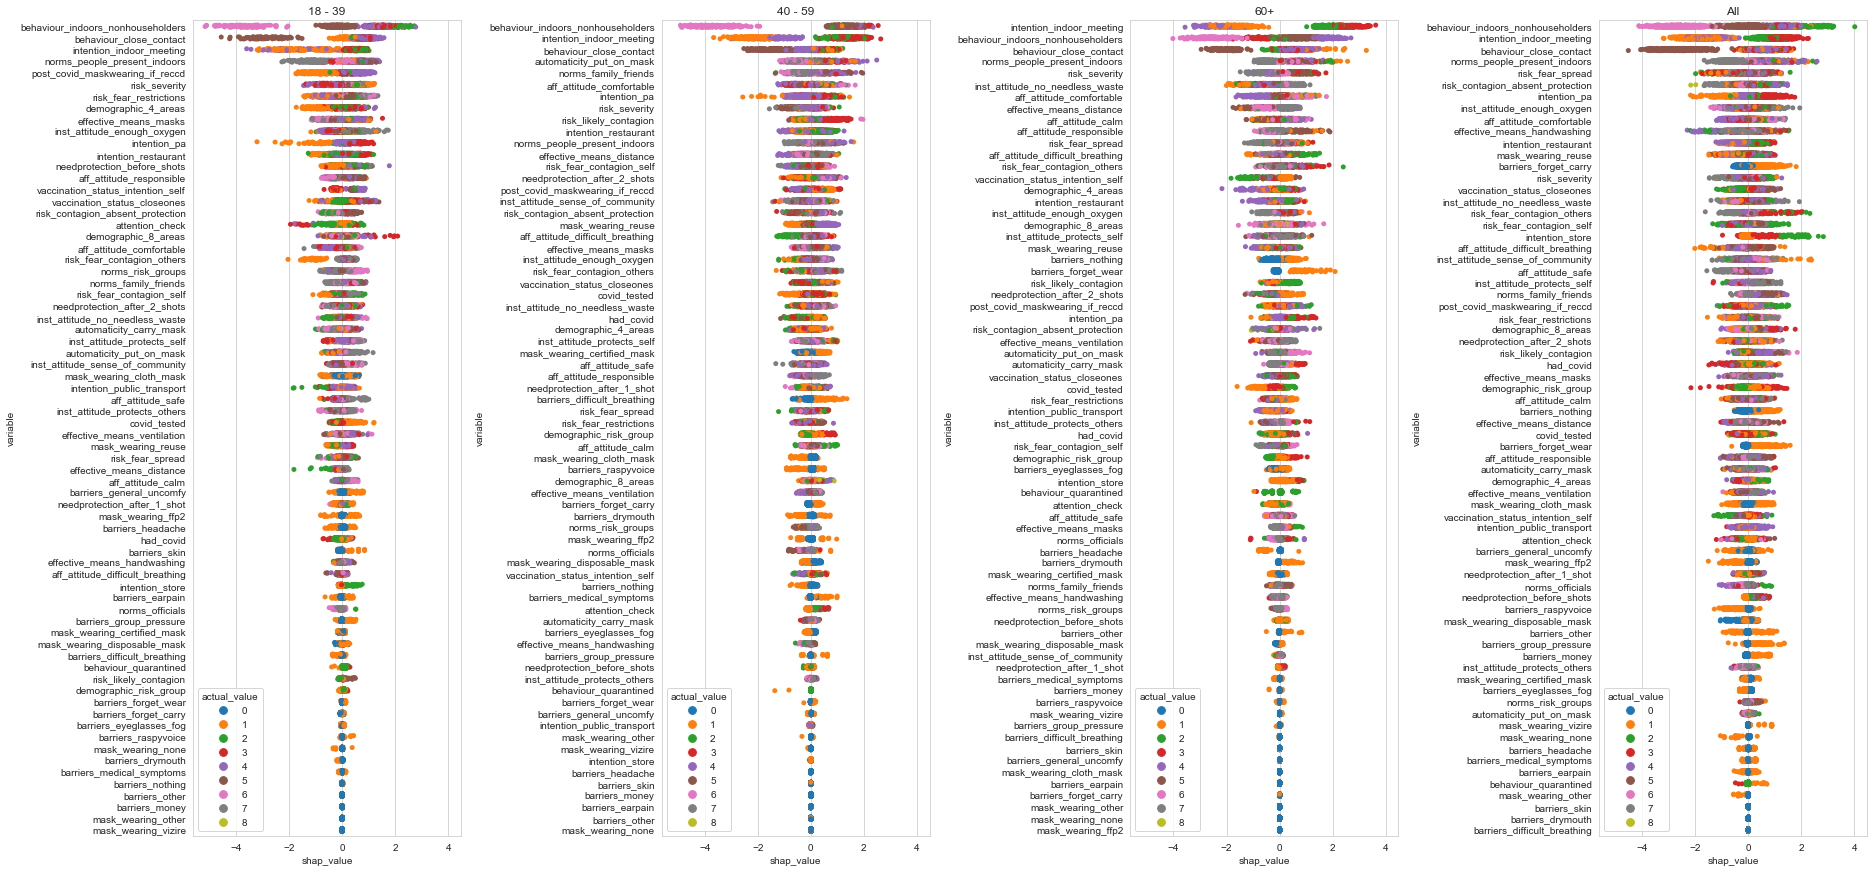

In [38]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 15),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
    _ = axs[i].set_title(shap_titles_list[i])
# _ = plt.show()

In [39]:
fig.savefig(f"images/shap_values_all_age_groups.png", dpi=400, bbox_inches="tight")

In [40]:
# shap_plot_3.suptitle("My title")
plot_title = "18 - 39"
shap_plot_0.suptitle(plot_title, y=0.89)
shap_plot_0.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "40 - 59"
shap_plot_1.suptitle(plot_title, y=0.89)
shap_plot_1.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "60+"
shap_plot_2.suptitle(plot_title, y=0.89)
shap_plot_2.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "All"
shap_plot_3.suptitle(plot_title, y=0.89)
shap_plot_3.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")

In [41]:
# dec_bound_plot_0

In [42]:
clf = CatBoostClassifier(iterations=500,
                           depth=None,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)

In [43]:
feature_importance_df_0.head(5).feature.tolist()

['behaviour_indoors_nonhouseholders',
 'behaviour_close_contact',
 'post_covid_maskwearing_if_reccd',
 'norms_people_present_indoors',
 'inst_attitude_enough_oxygen']

In [44]:
# tmp_df = df[df["demographic_age"].isin(['18-29', '30-39'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['40-49', '50-59'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['60+'])].reset_index()
tmp_df = df.reset_index()

# X = tmp_df[feature_importance_df_0.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_1.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_2.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_3.head(5).feature.tolist()]

X = tmp_df[features_list[2:]]

# X = tmp_df[df.filter(regex="sdt").columns.tolist()]

y = tmp_df[grouping_var]

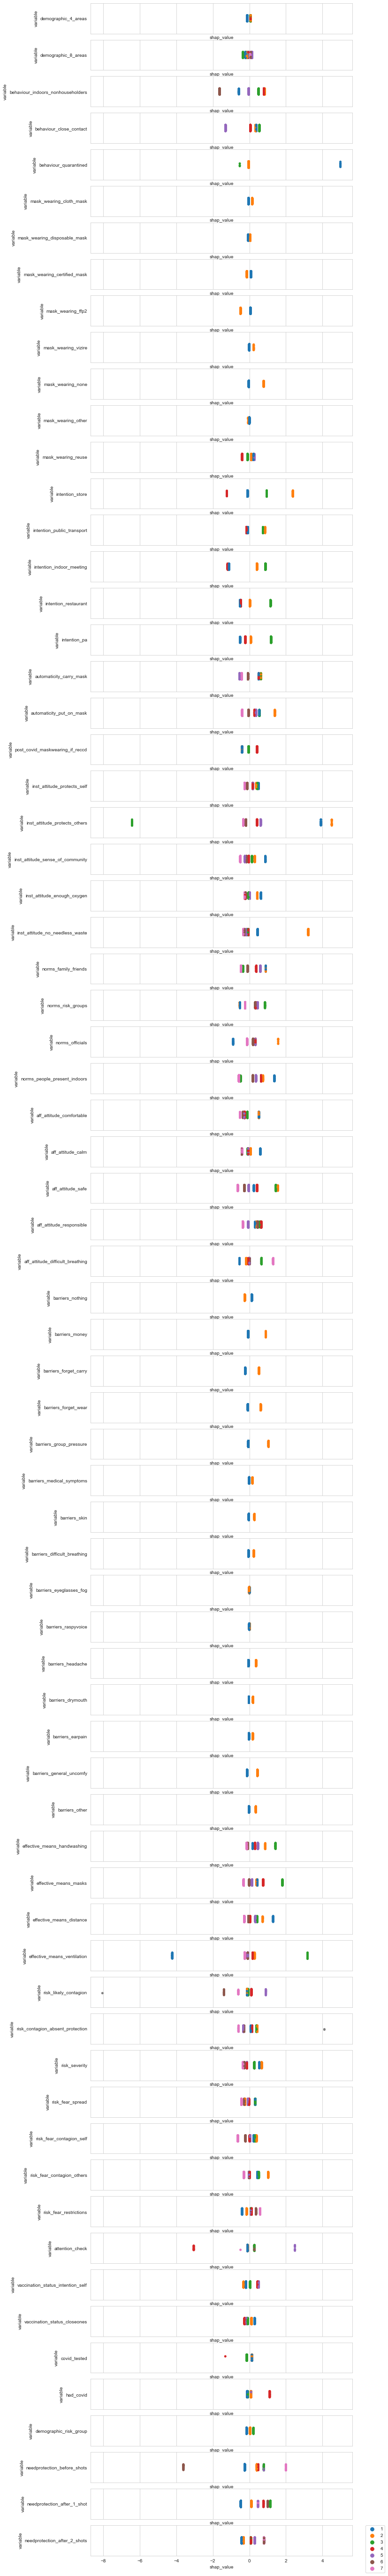

In [45]:
fig, axs = plt.subplots(nrows=X.shape[1],
                 ncols=1,
                 sharex=True,
                 sharey=False,
                       figsize=(10, 100),
#                        gridspec_kw={'wspace': 0.75
#                                    }
                       )

for i in range(0, X.shape[1]):

    feature = X.columns.tolist()[i]
    
    model = CatBoostClassifier(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='Logloss',
                               verbose=False)

    # train the model
    _ = model.fit(X[[feature]], y, cat_features=[feature]
                 )

    shap_values = model.get_feature_importance(Pool(X[[feature]], label=y,cat_features=[feature]), type="ShapValues")

    shap_values = shap_values[:,:-1]

    tmp_actual = (X[[feature]]
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=[feature])
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)
    
    if i == X.shape[1]-1:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend_.remove()

In [46]:
_ = fig.savefig(f"images/shap_values_ALL_analysis_seperate_per_feature.png", dpi=400, bbox_inches="tight")

>Train: 0=716, 1=1101, Test: 0=165, 1=290


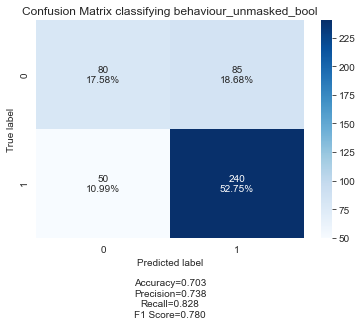

>Train: 0=685, 1=1132, Test: 0=196, 1=259


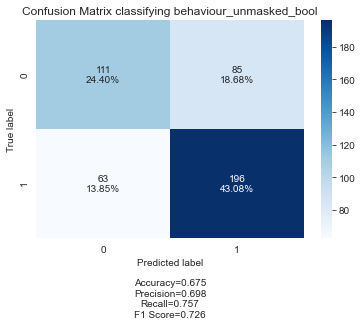

>Train: 0=701, 1=1117, Test: 0=180, 1=274


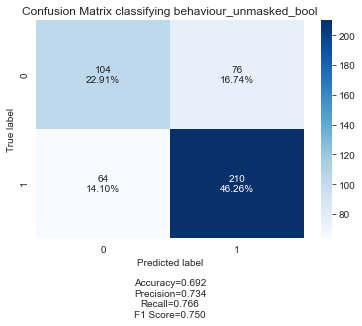

>Train: 0=721, 1=1097, Test: 0=160, 1=294


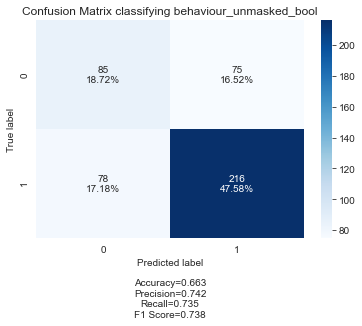

>Train: 0=701, 1=1117, Test: 0=180, 1=274


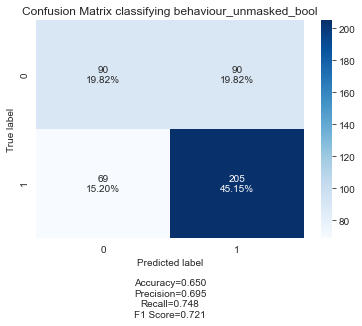

In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
                cat_features=X.columns)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()

In [48]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

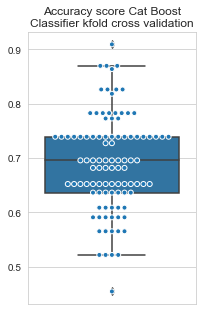

In [49]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Cat Boost\nClassifier kfold cross validation")

In [50]:
pd.DataFrame(accuracies_list).describe().T

count    mean       std       min       25%       50%      75%       max
0  100.0  0.6917  0.088892  0.454545  0.636364  0.695652  0.73913  0.909091

In [51]:
pd.DataFrame(clf.predict_proba(X)).head()

0         1
0  0.535641  0.464359
1  0.830877  0.169123
2  0.718360  0.281640
3  0.003501  0.996499
4  0.006234  0.993766

In [52]:
base_model = CatBoostClassifier(iterations=500,
                           depth=None,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)

In [53]:
model = BalancedBaggingClassifier(base_estimator=base_model, replacement=True)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean accuracy: %.3f' % np.mean(scores))

Mean accuracy: 0.707


In [54]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [55]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [56]:
scoring_list = ('accuracy',
 'balanced_accuracy',
#  'explained_variance',
 'f1',
#  'f1_macro',
#  'f1_micro',
#  'f1_samples',
 'f1_weighted',
#  'neg_log_loss',
#  'neg_root_mean_squared_error',
 'precision',
#  'precision_macro',
#  'precision_micro',
#  'precision_samples',
 'precision_weighted',
 'recall',
#  'recall_macro',
#  'recall_micro',
#  'recall_samples',
 'recall_weighted',
 'roc_auc',
               )

In [57]:
tmp_out = cross_validate(model, X, y, scoring=scoring_list, return_train_score=False, cv=cv, n_jobs=-1)

In [58]:
cv_metrics_df = pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).melt(var_name="Metric")

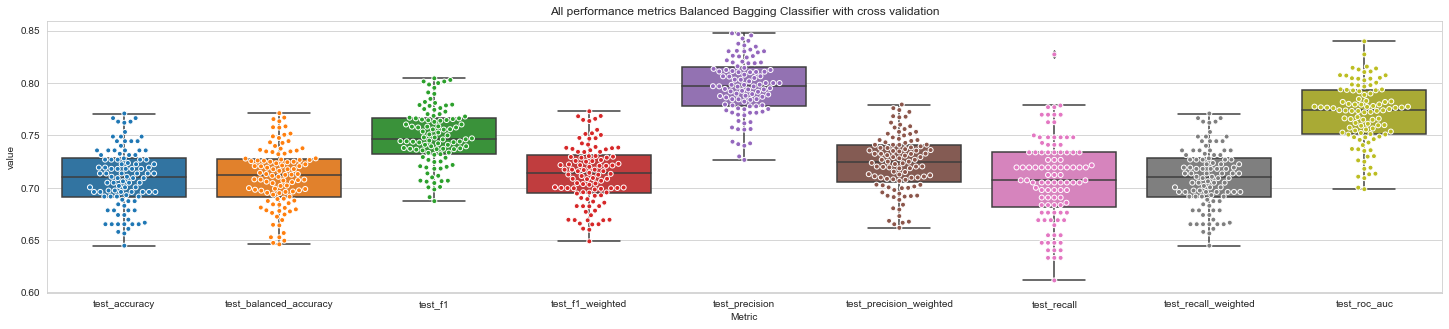

In [59]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = cv_metrics_df,
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = cv_metrics_df,
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title("All performance metrics Balanced Bagging Classifier with cross validation")

In [60]:
pd.DataFrame(scores).describe().T

count      mean       std       min       25%       50%       75%       max
0  100.0  0.707399  0.029389  0.635965  0.687225  0.705493  0.726872  0.784141

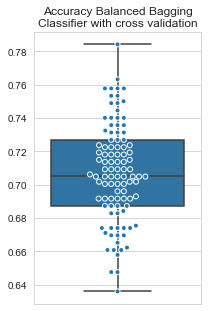

In [61]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = scores)
_ = sns.swarmplot(y = scores, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy Balanced Bagging\nClassifier with cross validation")

In [62]:
class_metrics_df = pd.DataFrame()
kfold = KFold(n_splits=50, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))
    
    current_metrics_df = summary_performance_metrics_classification(y_true=test_y, 
                                                                    y_pred=pred_y)
    class_metrics_df = pd.concat([class_metrics_df, current_metrics_df])

In [63]:
# class_metrics_df.melt(var_name="Metric")

In [64]:
metric_cols = ['Accuracy', 'Balanced Accuracy', 'Prevalence', 'Sensitivity',
       'Specificity', 'PPV', 'NPV', 'auc', 'F1']
TF_value = ['TN', 'FP', 'FN', 'TP']

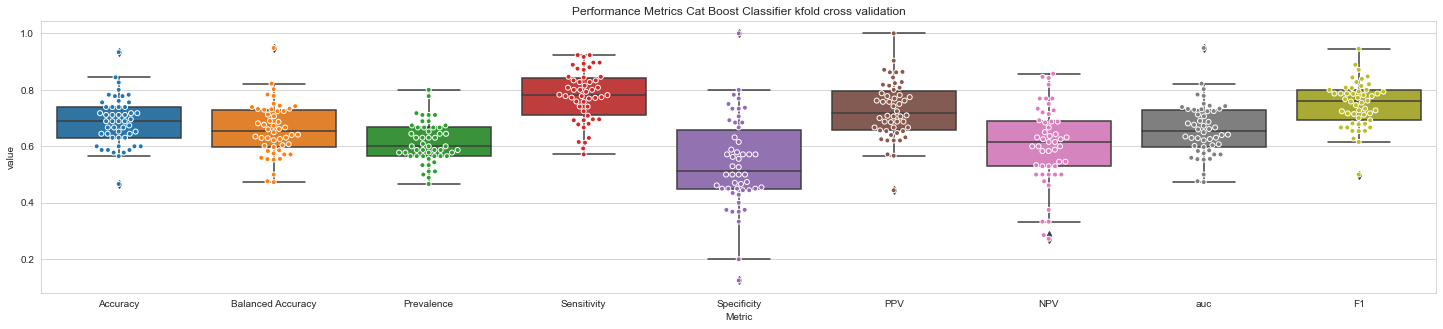

In [65]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = class_metrics_df[metric_cols].melt(var_name="Metric"),
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = class_metrics_df[metric_cols].melt(var_name="Metric"),
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title("Performance Metrics Cat Boost Classifier kfold cross validation")

In [66]:
# _ = plt.figure(figsize=(25,5))
# _ = sns.boxplot(data = class_metrics_df[TF_value].melt(var_name="Metric"),
#                 x = "Metric",
#                 y = "value")
# _ = sns.swarmplot(data = class_metrics_df[TF_value].melt(var_name="Metric"),
#                 x = "Metric",
#                 y = "value", edgecolor="white", linewidth=1)
# _ = plt.title("Performance Metrics Cat Boost Classifier kfold cross validation")

In [67]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# # kfold = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
# # enumerate the splits and summarize the distributions
# for train_ix, test_ix in kfold.split(X):
#     # select rows
#     train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
#     train_y, test_y = y.loc[train_ix], y.loc[test_ix]
#     # summarize train and test composition
#     train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
#     test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
# #     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
#     _ = clf.fit(X = train_X, 
#                 y = train_y,
#                cat_features=X.columns)
    
#     pred_y = clf.predict(test_X)
#     _ = accuracies_list.append(accuracy_score(test_y, pred_y))
    
#     current_metrics_df = summary_performance_metrics_classification(y_true=test_y, 
#                                                                     y_pred=pred_y)
#     class_metrics_df = pd.concat([class_metrics_df, current_metrics_df])